In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
import time

import lale.lib.aif360
import lale.lib.rasl
import lale.lib.xgboost

2023-07-25 13:20:39.756232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 13:20:39.969258: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-25 13:20:40.754285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-25 13:20:40.754444: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
dataset_names = {
    "adult": "adult",
    "bank": "bank",
    "compas": "compas",
    "compas_violent": "compas_violent",
    "creditg": "creditg",
    "default_credit": "default_credit",
    "heart_disease": "heart_disease",
    "law_school": "law_school",
    "meps19": "meps_panel19_fy2015",
    "meps20": "meps_panel20_fy2015",
    "meps21": "meps_panel21_fy2016",
    "nlsy": "nlsy",
    "nursery": "nursery",
    "ricci": "ricci",
    "speeddating": "speeddating",
    "student_math": "student_math",
    "student_por": "student_por",
    "tae": "tae",
    "titanic": "titanic",
    "us_crime": "us_crime",
}
datasets = {
    name: getattr(lale.lib.aif360.datasets, f"fetch_{long_name}_df")()
    for name, long_name in dataset_names.items()
}

In [3]:
dataset_origins = {
    "adult": "OpenML",
    "bank": "OpenML",
    "compas": "ProPublica",
    "compas_violent": "ProPublica",
    "creditg": "OpenML",
    "default_credit": "OpenML",
    "heart_disease": "OpenML",
    "law_school": "OpenML",
    "meps19": "AHRQ",
    "meps20": "AHRQ",
    "meps21": "AHRQ",
    "nlsy": "OpenML",
    "nursery": "OpenML",
    "ricci": "OpenML",
    "speeddating": "OpenML",
    "student_math": "OpenML",
    "student_por": "OpenML",
    "tae": "OpenML",
    "titanic": "OpenML",
    "us_crime": "OpenML",
}

In [4]:
def format_protected_attribute(pattrs, index):
    return " " if len(pattrs) <= index else pattrs[index]["feature"]

def get_static_info(dataset_name):
    X, y, fairness_info = datasets[dataset_name]
    pattrs = fairness_info["protected_attributes"]
    assert 1 <= len(pattrs) <= 2, pattrs
    result = {
        "name": dataset_name,
        "origin": dataset_origins[dataset_name],
        "n_rows": len(X),
        "n_cols": X.shape[1],
        "any_categorical": any(not np.issubdtype(t, np.number) for t in X.dtypes),
        "any_missing": X.isna().any().any(),
        "n_labels": len(y.unique()),
        "target_name": y.name,
        "fav_labels": str(fairness_info["favorable_labels"][0]),
        "prot_attr_0": format_protected_attribute(pattrs, 0),
        "prot_attr_1": format_protected_attribute(pattrs, 1),
    }
    return result

static_info = pd.DataFrame(
    get_static_info(name) for name in datasets
).sort_values("n_rows").reset_index(drop=True)

In [5]:
static_info.style.format({
    c: "{:,d}" for c in ["n_labels", "n_rows", "n_cols"]
})

,name,origin,n_rows,n_cols,any_categorical,any_missing,n_labels,target_name,fav_labels,prot_attr_0,prot_attr_1
0,ricci,OpenML,118,5,True,False,2,promotion,Promotion,race,
1,tae,OpenML,151,5,False,False,3,class_attribute,3,whether_of_not_the_ta_is_a_native_english_speaker,
2,heart_disease,OpenML,303,13,False,False,2,target,1,age,
3,student_math,OpenML,395,32,True,False,2,g3_ge_10,1,sex,age
4,student_por,OpenML,649,32,True,False,2,g3_ge_10,1,sex,age
5,creditg,OpenML,"1,000",20,True,False,2,class,good,personal_status,age
6,titanic,OpenML,"1,309",13,True,True,2,survived,1,sex,
7,us_crime,OpenML,"1,994",102,True,False,2,crimegt70pct,0,blackgt6pct,
8,compas_violent,ProPublica,"4,020",51,True,True,2,two_year_recid,0,sex,race
9,nlsy,OpenML,"4,908",15,True,False,2,income96gt17,1,age,gender


In [6]:
sorted_dataset_names = list(static_info["name"])

In [7]:
def symmetric_class_imbalance(X, y, fairness_info):
    pae = lale.lib.aif360.ProtectedAttributesEncoder(**fairness_info)
    _, encoded_y = pae.fit(X, y).transform_X_y(X, y)
    vcs = encoded_y.value_counts().to_dict()
    imbalance = vcs[0] / vcs[1]
    return imbalance if imbalance < 1 else 1 / imbalance

def make_prep(X):
    any_missing = X.isna().any().any()
    cols_num = [c for c, t in zip(X.columns, X.dtypes) if np.issubdtype(t, np.number)]
    cols_cat = [c for c in X.columns if c not in cols_num]
    if len(cols_num) > 0:
        prep_num = lale.lib.rasl.Project(columns=cols_num)
        if any_missing:
            prep_num = prep_num >> lale.lib.sklearn.SimpleImputer(strategy="mean")
    if len(cols_cat) > 0:
        prep_cat = lale.lib.rasl.Project(columns=cols_cat)
        if any_missing:
            prep_cat = prep_cat >> lale.lib.sklearn.SimpleImputer(strategy="most_frequent")
        prep_cat = prep_cat >> lale.lib.sklearn.OrdinalEncoder(handle_unknown="ignore")
    if len(cols_num) == 0 and len(cols_cat) > 0:
        result = prep_cat
    elif len(cols_num) > 0 and len(cols_cat) == 0:
        result = prep_num
    else:
        result = (prep_cat & prep_num) >> lale.lib.rasl.ConcatFeatures
    if X.shape[1] > 32:
        result = result >> lale.lib.sklearn.SelectKBest(k=32)
    return result

def get_metrics(dataset_name):
    start_time = time.time()
    X, y, fairness_info = datasets[dataset_name]
    print(f"get_metrics({dataset_name}), {len(X):,d} rows")
    scoring={
        "ba": sklearn.metrics.make_scorer(sklearn.metrics.balanced_accuracy_score),
        "di": lale.lib.aif360.symmetric_disparate_impact(**fairness_info),
        "eo": lale.lib.aif360.equal_opportunity_difference(**fairness_info),
    }
    estimator = make_prep(X) >> lale.lib.xgboost.XGBClassifier()
    estimator.visualize()
    xgb_scores = sklearn.model_selection.cross_validate(
        estimator=estimator,
        X=X, y=y, scoring=scoring,
        cv=lale.lib.aif360.FairStratifiedKFold(**fairness_info),
    )
    result = {
        "name": dataset_name,
        "n_rows": len(X),
        "data_ci": symmetric_class_imbalance(X, y, fairness_info),
        "data_di": scoring["di"].score_data(X=X, y_pred=y),
        "xgb_di": xgb_scores["test_di"].mean(),
        "xgb_di_std": xgb_scores["test_di"].std(),
        "xgb_eo": xgb_scores["test_eo"].mean(),
        "xgb_eo_std": xgb_scores["test_eo"].std(),
        "xgb_ba": xgb_scores["test_ba"].mean(),
        "xgb_ba_std": xgb_scores["test_ba"].std(),
    }
    print(f"  elapsed time {time.time() - start_time:,.1f} seconds")
    return result

get_metrics(ricci), 118 rows


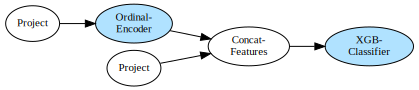

  elapsed time 2.2 seconds
get_metrics(tae), 151 rows


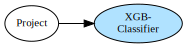

  elapsed time 2.1 seconds
get_metrics(heart_disease), 303 rows


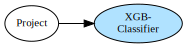

  elapsed time 1.8 seconds
get_metrics(student_math), 395 rows


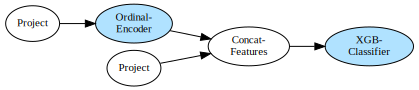

  elapsed time 2.1 seconds
get_metrics(student_por), 649 rows


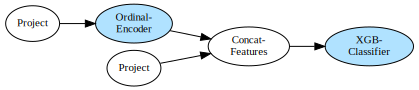

  elapsed time 2.0 seconds
get_metrics(creditg), 1,000 rows


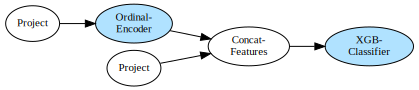

  elapsed time 2.2 seconds
get_metrics(titanic), 1,309 rows


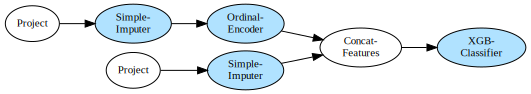

  elapsed time 2.2 seconds
get_metrics(us_crime), 1,994 rows


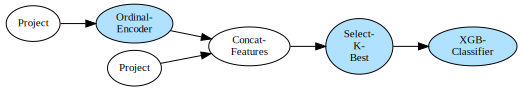

/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/

  elapsed time 4.1 seconds
get_metrics(compas_violent), 4,020 rows


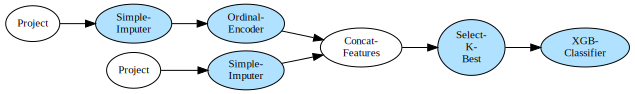

/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [25 28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/pyth

  elapsed time 5.2 seconds
get_metrics(nlsy), 4,908 rows


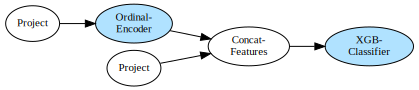

  elapsed time 3.9 seconds
get_metrics(compas), 6,172 rows


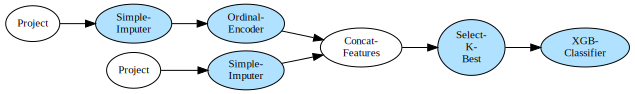

/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [25 28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/pyth

  elapsed time 8.2 seconds
get_metrics(speeddating), 8,378 rows


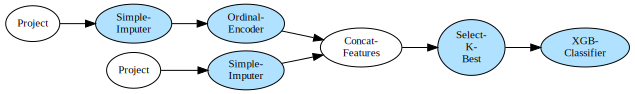

/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/

  elapsed time 9.6 seconds
get_metrics(nursery), 12,960 rows


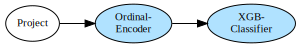

/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  elapsed time 11.9 seconds
get_metrics(meps19), 16,578 rows


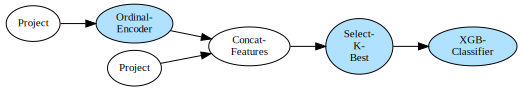

/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  15   64 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070 1071
 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1277 1278 1313
 1346 1426 1476 1477 1512 1594 1609 1610 1612 1613 1615 1625 1626 1627
 1628 1629 1631 1632 1676 1726 1729 1731 1732 1744 1757 1760 1761 1762
 1763 1764 1765 1780 1794] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X d

  elapsed time 41.0 seconds
get_metrics(meps21), 17,052 rows


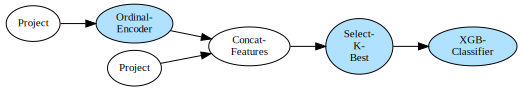

/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  15   64  627  630 1387 1422 1423 1439 1503 1536 1569 1586 1621 1622
 1704 1719 1721 1722 1723 1724 1725 1735 1737 1738 1739 1741 1786 1835
 1837 1838 1839 1853 1856 1869 1871 1873 1875 1890 1905] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/py

  elapsed time 40.4 seconds
get_metrics(meps20), 18,849 rows


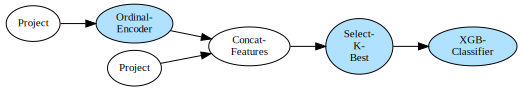

/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  15   64  109  515  518 1277 1312 1313 1315 1346 1459 1511 1512 1514
 1545 1594 1609 1611 1612 1613 1615 1625 1626 1627 1628 1629 1631 1632
 1727 1728 1729 1744 1759 1761 1762 1763 1765 1766 1794] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(
/home/hirzel/py

  elapsed time 41.3 seconds
get_metrics(law_school), 20,800 rows


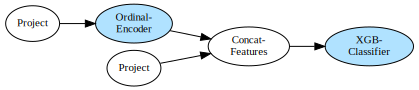

  elapsed time 4.1 seconds
get_metrics(default_credit), 30,000 rows


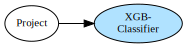

  elapsed time 42.0 seconds
get_metrics(bank), 45,211 rows


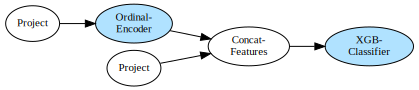

  elapsed time 28.6 seconds
get_metrics(adult), 48,842 rows


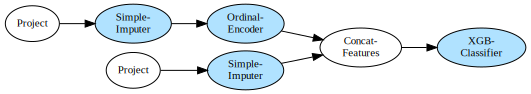

  elapsed time 25.6 seconds


In [8]:
metrics_df = pd.DataFrame(
    get_metrics(name) for name in sorted_dataset_names
).sort_values("n_rows").reset_index(drop=True)

In [9]:
metrics_df.style.format({
    "n_rows": "{:,d}",
    **{c: "{:.1%}" for c in metrics_df.columns if c not in ["name", "n_rows"]},
})

,name,n_rows,data_ci,data_di,xgb_di,xgb_di_std,xgb_eo,xgb_eo_std,xgb_ba,xgb_ba_std
0,ricci,118,90.3%,49.8%,50.3%,4.7%,2.5%,5.0%,98.3%,2.1%
1,tae,151,52.5%,44.9%,38.1%,17.5%,1.9%,15.2%,65.0%,24.9%
2,heart_disease,303,83.6%,58.9%,58.6%,16.6%,-20.2%,17.3%,80.9%,5.9%
3,student_math,395,69.5%,89.4%,85.0%,9.4%,8.9%,5.8%,93.3%,3.0%
4,student_por,649,18.2%,85.8%,86.5%,4.0%,-2.9%,4.9%,83.1%,7.7%
5,creditg,"1,000",42.9%,74.8%,71.7%,13.3%,-17.1%,14.1%,68.6%,3.5%
6,titanic,"1,309",61.8%,26.3%,25.3%,1.6%,-0.3%,5.1%,94.4%,2.0%
7,us_crime,"1,994",6.5%,88.8%,92.6%,1.9%,-3.6%,1.5%,65.9%,5.4%
8,compas_violent,"4,020",19.4%,85.2%,84.8%,0.8%,-0.7%,0.3%,99.2%,0.5%
9,nlsy,"4,908",60.7%,66.8%,59.6%,4.0%,-24.3%,5.7%,64.7%,2.2%


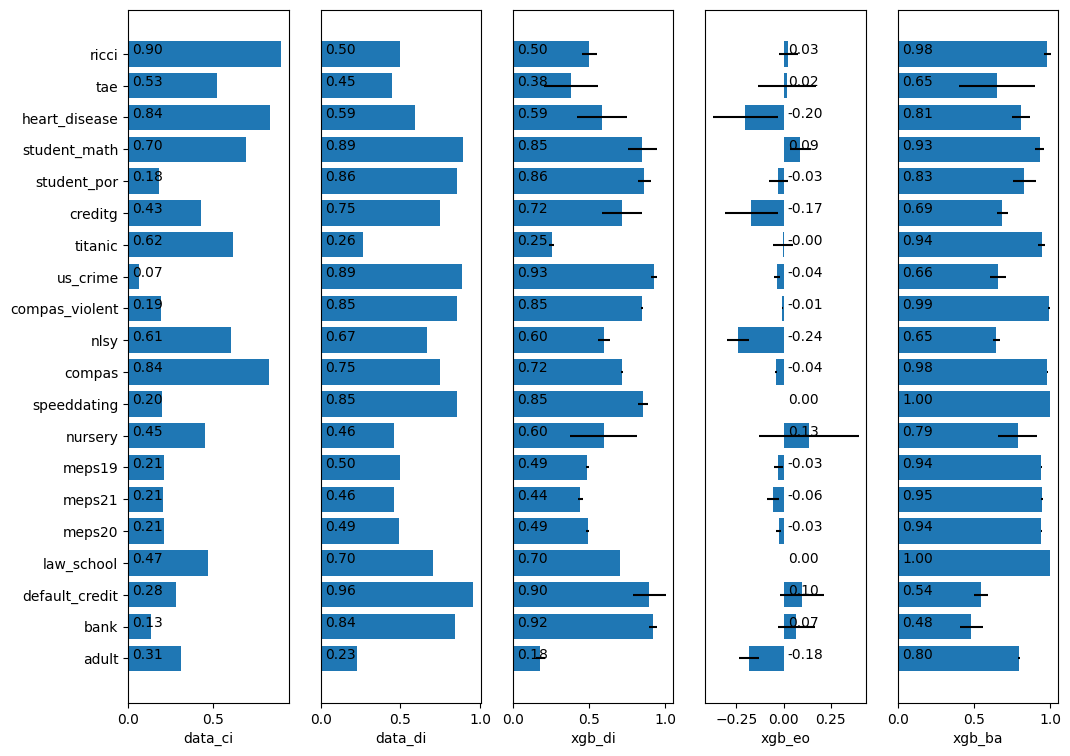

In [10]:
metric_names = [
    c for c in metrics_df.columns
    if c not in ["name", "n_rows"] and not c.endswith("_std")
]
figs, axs = plt.subplots(1, len(metric_names), figsize=(12, 9))
for i, metric_name in enumerate(metric_names):
    ax = axs[i]
    y_pos = np.arange(len(metrics_df))
    ax.barh(
        y=y_pos,
        width=metrics_df[metric_name],
        xerr=metrics_df[metric_name + "_std"] if metric_name + "_std" in metrics_df.columns else None,
        align="center",
    )
    if i == 0:
        ax.set_yticks(y_pos, labels=metrics_df["name"])
    else:
        ax.tick_params(labelleft=False, left=False)
    ax.invert_yaxis()
    for j in metrics_df.index:
        ax.annotate(
            f"{metrics_df[metric_name][j]:.2f}",
            (0, j),
            textcoords="offset points",
            xytext=(3, 0),
        )
    ax.set_xlabel(metric_name)